An example for finding raw data which can be interpolated onto a specific LST range.

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from pyuvdata import UVData
from scipy.interpolate import CubicSpline
from astropy import units as u, constants as c
import pandas as pd
import os
from astropy.coordinates import Angle

Define the LST grid.

In [36]:
# Set up LST grid; in radians
# A trifle worried about numerical precision, but let's plunge ahead

# Files will be this long
lst_bin_size = 6.*u.min
n_lst_bins = int((24.*u.hr/lst_bin_size).to(u.dimensionless_unscaled).value)
lst_edges = np.linspace(0, 2.*np.pi, n_lst_bins+1, endpoint=True)
lst_start = lst_edges[0:-1]
lst_end = lst_edges[1:]
lst_mid = (lst_start + lst_end)/2.

assert len(lst_start) == n_lst_bins
assert len(lst_end) == n_lst_bins
assert np.isclose((lst_end-lst_start)*24.*60./(2.*np.pi), lst_bin_size.value).sum() == n_lst_bins

# Need to specify the time sampling within a "bin"
lst_time_sample = 10*u.s # This is actually every 10 sidereal seconds
n_samples = int((lst_bin_size/lst_time_sample).to(u.dimensionless_unscaled).value)
lst_sampling = ((np.arange(n_samples)*lst_time_sample)/(24*u.hr)).to(u.dimensionless_unscaled).value*2.*np.pi

In [63]:
JD = '2457548'
rawpath = '/lustre/aoc/projects/hera/jaguirre/HERA19Summer2020/RawData/'+JD+'/'

In [64]:
# Grab the summary file for the day in question
summary = pd.read_csv(os.path.join(rawpath,JD+'_summary.csv'))
filenames_all = np.array(summary['Filename'])
lsts_all = np.array(summary['LST (rad)'])
jds_all = np.array(summary['Julian Date'])

In [65]:
summary

,Unnamed: 0,Filename,Julian Date,LST (rad),UTC,LST (hr),Sun alt (deg)
0,0,zen.2457548.16694.uvcRP.uvh5,2.457548e+06,2.775293,2016-06-08 16:00:28.748,10h36m03.0181s,-4.900503
1,1,zen.2457548.16694.uvcRP.uvh5,2.457548e+06,2.776076,2016-06-08 16:00:39.486,10h36m13.7849s,-4.935693
2,2,zen.2457548.16694.uvcRP.uvh5,2.457548e+06,2.776859,2016-06-08 16:00:50.223,10h36m24.5518s,-4.970890
3,3,zen.2457548.16694.uvcRP.uvh5,2.457548e+06,2.777642,2016-06-08 16:01:00.961,10h36m35.3186s,-5.006092
4,4,zen.2457548.16694.uvcRP.uvh5,2.457548e+06,2.778425,2016-06-08 16:01:11.698,10h36m46.0854s,-5.041300
...,...,...,...,...,...,...,...
4016,4016,zen.2457548.66106.uvcRP.uvh5,2.457549e+06,5.919761,2016-06-09 03:59:10.220,22h36m42.5535s,-18.519717
4017,4017,zen.2457548.66106.uvcRP.uvh5,2.457549e+06,5.920544,2016-06-09 03:59:20.958,22h36m53.3203s,-18.482800
4018,4018,zen.2457548.66106.uvcRP.uvh5,2.457549e+06,5.921327,2016-06-09 03:59:31.695,22h37m04.0871s,-18.445888
4019,4019,zen.2457548.66106.uvcRP.uvh5,2.457549e+06,5.922110,2016-06-09 03:59:42.432,22h37m14.8539s,-18.408979


In [66]:
summary['LST (rad)'].min(), summary['LST (rad)'].max()

(2.7752929952610765, 5.922892677437498)

In [ ]:
# Final version will loop over all the LST bins and find appropriate data (if available)
# Might be something like the following ...

# Probably want to calculate how many time samples *should* appear ...
min_time_samp = 1
for i in np.arange(n_lst_bins):
    lst_min = lst_start[i]
    lst_max = lst_end[i]
    lst_range = np.logical_and(lsts >= lst_min, lsts < lst_max)
    #print(lst_min*24./(2.*np.pi), lst_range.sum())
    
    if lst_range.sum() > min_time_samp:
        lst_min_str = Angle(lst_min, u.rad).to_string(unit=u.hr)
        lst_max_str = Angle(lst_max, u.rad).to_string(unit=u.hr)
        lst_filename = 'lst.'+JD+'.'+lst_min_str+'.'+lst_max_str+'.uvcRP.drift.uvh5'
        print(lst_filename)
        jd_to_select = jds[lst_range]
        files_to_read = path + np.unique(filenames[lst_range])
        uvd = UVData()
        uvd.read(files_to_read)
        lsts_in_file = np.unique(uvd.lst_array)
        uvd.select(time_range=[jd_to_select.min()-one_second, jd_to_select.max()+one_second])
        uvd.write_uvh5(os.path.join(path, lst_filename), clobber=True)

In [67]:
# We're going to pick this LST bin
lst_min = lst_start[120]
lst_max = lst_end[120]

pad = 30/3600.*2.*np.pi/24.
lst_range = np.logical_and(lsts_all >= lst_min-pad, lsts_all < lst_max+pad)
lst_min, lst_max, lst_range.sum()

(3.141592653589793, 3.1677725923697078, 39)

In [68]:
lst_min_str = Angle(lst_min, u.rad).to_string(unit=u.hr)
lst_max_str = Angle(lst_max-lst_sampling[1], u.rad).to_string(unit=u.hr)
lst_filename = 'lst.'+JD+'.'+lst_min_str+'.'+lst_max_str+'.uvcRP.drift.uvh5'
lst_filename

'lst.2457548.12h00m00s.12h05m50s.uvcRP.drift.uvh5'

In [69]:
files_to_read = rawpath+np.unique(filenames[lst_range])

In [70]:
files_to_read

array(['/lustre/aoc/projects/hera/jaguirre/HERA19Summer2020/RawData/2457548/zen.2457548.22261.uvcRP.uvh5',
       '/lustre/aoc/projects/hera/jaguirre/HERA19Summer2020/RawData/2457548/zen.2457548.22957.uvcRP.uvh5'],
      dtype=object)

In [71]:
uvd_raw = UVData()

In [72]:
uvd_raw.read(files_to_read)

In [73]:
uvd_raw.Ntimes

112

In [74]:
def jd_at_lst(uvdata, lst0):
    """ Given a UVData object, find the JD corresponding to the requested LST.  
    Uses simple linear interpolation. """
    jd = np.unique(uvdata.time_array)
    lst = np.unique(uvdata.lst_array)
    
    return np.interp(lst0, lst, jd)

In [76]:
lsts = np.unique(uvd_raw.lst_array) # For some God-forsaken reason, LSTs are in radians
jds = np.unique(uvd_raw.time_array)

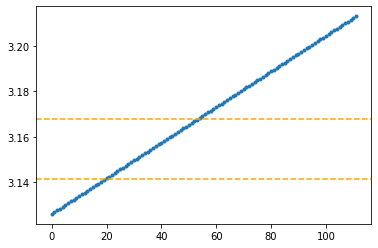

In [80]:
plt.plot(lsts,'.')
plt.axhline(lst_min,linestyle='--',color='orange')
plt.axhline(lst_max,linestyle='--',color='orange')

In [82]:
Ntimes = len(lst_sampling)
Ntimes

36

In [83]:
""" You can set the LSTs from the time set_lsts_from_time_array, but here the whole point is to fix the LST, and then
get the corresponding JD.  I hope linear interpolation is sufficiently accurate. """
lsts_new = lst_min + lst_sampling
jds_new = jd_at_lst(uvd_raw, lsts_new) 

In [88]:
# OK, this is going to be painful.  Build a new UVData object.
# The required attributes are a method

In [89]:
# for some dumb reason, the attributes are returned with leading underscore
# Build up the list of required attributes
attributes = list(uvd_raw.__dict__.keys())
#print(attributes)
for i,attribute in enumerate(attributes):
    if attribute[0] == '_':
        attributes[i] = attribute[1:]
#print()
#print(attributes)

In [90]:
# Define new array dimenions or copy over ...
Nbls = uvd_raw.Nbls
Nblts = Ntimes * Nbls
Nspws = uvd_raw.Nspws
Nfreqs = uvd_raw.Nfreqs
Npols = uvd_raw.Npols

In [92]:
# The surprising variable here is the antenna array, which for some reason 
# needs to know about the number of time samples
data_array_new = np.zeros_like(uvd_raw.data_array, shape = [Nblts, Nspws, Nfreqs, Npols])
flag_array_new = np.zeros_like(uvd_raw.flag_array, shape = [Nblts, Nspws, Nfreqs, Npols])
nsample_array_new = np.ones_like(uvd_raw.nsample_array, shape = [Nblts, Nspws, Nfreqs, Npols])
uvw_array_new = np.zeros_like(uvd_raw.uvw_array, shape=[Nblts, 3])
time_array_new = np.zeros_like(uvd_raw.time_array, shape=[Nblts])
lst_array_new = np.zeros_like(uvd_raw.lst_array, shape=[Nblts])
ant_1_array_new = np.zeros_like(uvd_raw.ant_1_array, shape=[Nblts])
ant_2_array_new = np.zeros_like(uvd_raw.ant_2_array, shape=[Nblts])
baseline_array_new = np.zeros_like(uvd_raw.baseline_array, shape=[Nblts])
integration_time_new = np.zeros_like(uvd_raw.integration_time, shape=[Nblts])

In [93]:
# The below variables just have their data copied over, albeit to a new number of time samples

# None of this is going to be BDA-proof, and it also assumes that we're in drift mode: uvw and ant_N_array 
# do not change with time.  

# I just cannot figure out a way to do this that is BDA-proof ... maybe uvd_raw.resample_in_time?
# So we'll do it the stupid way
# There's probably a reshape that is smarter ...
for itime in np.arange(Ntimes):
    for ibl in np.arange(Nbls):
        indx = itime * Nbls + ibl
        # If in drift mode, they're all the same
        uvw_array_new[indx, :] = uvd_raw.uvw_array[0, :]
        time_array_new[indx] = jds_new[itime]
        lst_array_new[indx] = lsts_new[itime]
        # we're really assuming the pattern repeats every time sample ...
        ant_1_array_new[indx] = uvd_raw.ant_1_array[ibl]
        ant_2_array_new[indx] = uvd_raw.ant_2_array[ibl]          

In [94]:
# What do we need to change?
to_change = {'Ntimes' : Ntimes,
             'Nblts' : Nblts,
             'data_array' : data_array_new,
             'flag_array' : flag_array_new, # ... hoo boy
             'nsample_array' : nsample_array_new, # what?
             'uvw_array' : uvw_array_new, #... need to confirm we're drift scanning
             'time_array' : time_array_new, 
             'lst_array' : lst_array_new, 
             'integration_time' : integration_time_new,
             'ant_1_array' : ant_1_array_new, # why God, why?
             'ant_2_array' : ant_2_array_new,
             'baseline_array' : baseline_array_new # Oh, fuck my life
            }

In [95]:
uvd_new = UVData()
bl = (9, 10, 'ne')
for attribute in attributes:
    if attribute in to_change.keys():
        print('Changing '+attribute)
        setattr(uvd_new, attribute, to_change[attribute])
    else:
        print('Keeping '+attribute)
        setattr(uvd_new, attribute, getattr(uvd_raw, attribute))
    try:
        blt_ind1, blt_ind2, pol_ind = uvd_new._key2inds(bl)
        print('blt_ind1', blt_ind1.shape)
    except:
        print('Cannot get key2ind')
    #print(uvd_new.Ntimes)

Changing Ntimes
Cannot get key2ind
Keeping Nbls
Cannot get key2ind
Changing Nblts
Cannot get key2ind
Keeping Nfreqs
Cannot get key2ind
Keeping Npols
Cannot get key2ind
Changing data_array
Cannot get key2ind
Keeping vis_units
Cannot get key2ind
Changing nsample_array
Cannot get key2ind
Changing flag_array
Cannot get key2ind
Keeping Nspws
Cannot get key2ind
Keeping spw_array
Cannot get key2ind
Changing uvw_array
Cannot get key2ind
Changing time_array
Cannot get key2ind
Changing lst_array
Cannot get key2ind
Changing ant_1_array
Cannot get key2ind
Changing ant_2_array
Cannot get key2ind
Changing baseline_array
Cannot get key2ind
Keeping freq_array
Cannot get key2ind
Keeping polarization_array
Cannot get key2ind
Changing integration_time
Cannot get key2ind
Keeping channel_width
Cannot get key2ind
Keeping object_name
Cannot get key2ind
Keeping telescope_name
Cannot get key2ind
Keeping instrument
Cannot get key2ind
Keeping telescope_location
Cannot get key2ind
Keeping history
Cannot get key2i

In [96]:
uvd_raw.Ntimes

112

In [97]:
uvd_new.Ntimes

36

In [98]:
uvd_raw.integration_time

array([10.73741817, 10.73741817, 10.73741817, ..., 10.73741817,
       10.73741817, 10.73741817])

In [99]:
uvd_new.integration_time[:] = uvd_new._calc_single_integration_time()

In [100]:
uvd_new.integration_time

array([9.97270793, 9.97270793, 9.97270793, ..., 9.97270793, 9.97270793,
       9.97270793])

In [101]:
# I think this is a robust way to do this
uvd_new.baseline_array = uvd_new.antnums_to_baseline(uvd_new.ant_1_array, uvd_new.ant_2_array)

In [102]:
# Some checking
assert uvd_new.Nants_data == uvd_raw.Nants_data

In [130]:
def plot_raw_interp(data_raw, flags_raw, data_interp):
    
    fuck = np.isfinite(data_raw/~flags_raw)
    
    vmin_r = np.nanmin(data_raw.real[fuck])
    vmax_r = np.nanmax(data_raw.real[fuck])
    vmin_i = np.nanmin(data_raw.imag[fuck])
    vmax_i = np.nanmax(data_raw.imag[fuck])
    
    print(vmin_r, vmax_r, vmin_i, vmax_i)
    
    plt.figure(figsize=(12,8))
    plt.subplot(2,2,1)
    plt.imshow(data_raw.real/~flags_raw, aspect='auto', vmin=vmin_r, vmax=vmax_r)
    plt.colorbar()
    plt.subplot(2,2,2)
    plt.imshow(data_raw.imag/~flags_raw, aspect='auto', vmin=vmin_i, vmax=vmax_i)
    plt.colorbar()
    plt.subplot(2,2,3)
    plt.imshow(data_interp.real, aspect='auto', vmin=vmin_r, vmax=vmax_r)
    plt.colorbar()
    plt.subplot(2,2,4)
    plt.imshow(data_interp.imag, aspect='auto', vmin=vmin_i, vmax=vmax_i)
    plt.colorbar()
    plt.show()

In [132]:
%%time
# OK, now go through baseline by baseline to fix up the changed data ..
for bl in uvd_new.get_antpairpols()[0:9]:
    print(bl)
    data = uvd_raw.get_data(bl)
    # There might not be a good way to handle flagging that differs in time between frequencies ...
    # i.e., I think when the size of the unflagged data differs, you might just have to loop.  Ugh.
    # And then, if there is no good data ... double Ugh.
    flags = uvd_raw.get_flags(bl)
    data_interp = np.zeros_like(data, shape=[Ntimes, Nfreqs])
    flags_interp = np.zeros_like(flags, shape=[Ntimes, Nfreqs])
    
    for ifreq in np.arange(Nfreqs):
        fflags = ~flags[:,ifreq].squeeze()
        # If all the data are bad, skip
        if fflags.sum() >= 2:
            cs = CubicSpline(lsts[fflags], data[fflags, ifreq])
            data_interp[:, ifreq] = cs(lsts_new)
    
    # This was super clever for vectorizing the cubic spline across frequencies, but I don't think
    # it generalizes
    #cs = CubicSpline(lsts, data, axis=0)
    #interp = cs(lsts_new)
    
    # Need that magic incantation for shoving a visibility's data back into the UVData object
    inds = uvd_new._key2inds(bl)
    blt_inds = inds[0]
    pol_ind = inds[2][0]
    uvd_new.data_array[blt_inds,0,:,pol_ind] = data_interp
    uvd_new.flag_array[blt_inds,0,:,pol_ind] = flags_interp

(9, 9, 'xx')
(9, 9, 'yy')
(9, 9, 'xy')
(9, 9, 'yx')
(9, 10, 'xx')
(9, 10, 'yy')
(9, 10, 'xy')
(9, 10, 'yx')
(9, 20, 'xx')
CPU times: user 2.88 s, sys: 2.93 ms, total: 2.89 s
Wall time: 2.91 s


In [144]:
uvd_raw.select?

In [147]:
bl = (9,10,'xy')
uvd_raw_t = uvd_raw.select(bls=bl, time_range=[jds_new.min(), jds_new.max()], inplace=False)
data = uvd_raw_t.get_data(bl)
flags = uvd_raw_t.get_flags(bl)
data_interp = uvd_new.get_data(bl)

divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide


-0.17813682556152344 0.1790618896484375 -0.14047908782958984 0.19920730590820312


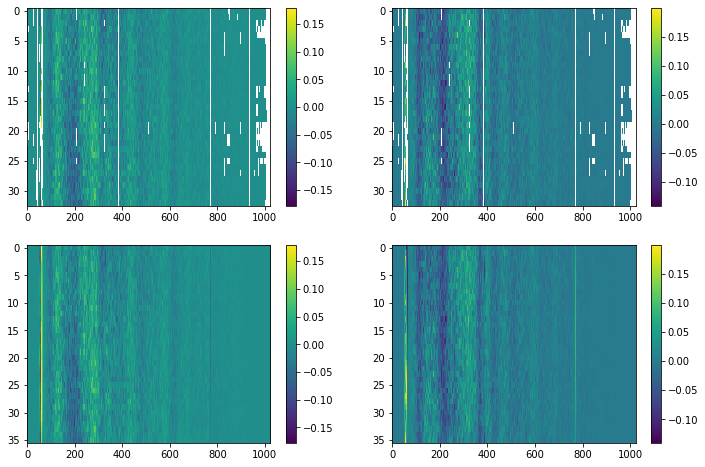

In [148]:
plot_raw_interp(data, flags, data_interp)

In [126]:
uvd_raw.flag_array.shape

(21280, 1, 1024, 4)

In [119]:
uvd_raw._key2inds((9,10,'xx'))

(array([    1,   191,   381,   571,   761,   951,  1141,  1331,  1521,
         1711,  1901,  2091,  2281,  2471,  2661,  2851,  3041,  3231,
         3421,  3611,  3801,  3991,  4181,  4371,  4561,  4751,  4941,
         5131,  5321,  5511,  5701,  5891,  6081,  6271,  6461,  6651,
         6841,  7031,  7221,  7411,  7601,  7791,  7981,  8171,  8361,
         8551,  8741,  8931,  9121,  9311,  9501,  9691,  9881, 10071,
        10261, 10451, 10641, 10831, 11021, 11211, 11401, 11591, 11781,
        11971, 12161, 12351, 12541, 12731, 12921, 13111, 13301, 13491,
        13681, 13871, 14061, 14251, 14441, 14631, 14821, 15011, 15201,
        15391, 15581, 15771, 15961, 16151, 16341, 16531, 16721, 16911,
        17101, 17291, 17481, 17671, 17861, 18051, 18241, 18431, 18621,
        18811, 19001, 19191, 19381, 19571, 19761, 19951, 20141, 20331,
        20521, 20711, 20901, 21091]),
 array([], dtype=int64),
 (array([0]), array([], dtype=int64)))

In [125]:
uvd_raw.data_array[uvd_raw._key2inds(bl)[0],0,:,uvd_raw._key2inds(bl)[2][0]].shape

(112, 1024)

In [124]:
uvd_raw._key2inds((9,10,'xx'))[2][0]

array([0])